In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine, euclidean, cityblock, canberra, braycurtis
import warnings
warnings.filterwarnings("ignore")

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict

In [5]:
data = pd.read_csv("data.csv")
genre_data = pd.read_csv('data_by_genres.csv')
year_data = pd.read_csv('data_by_year.csv')

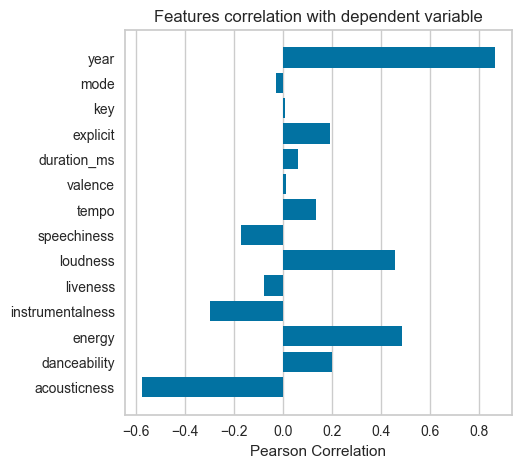

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [6]:

from yellowbrick.target import FeatureCorrelation

feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'duration_ms', 'explicit', 'key', 'mode', 'year']

X, y = data[feature_names], data['popularity']

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize'] = (5, 5)
visualizer.fit(X, y)     # Fit the data to the visualizer
visualizer.show()

In [7]:
cluster_pipeline = Pipeline(
    [('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=10))])
X = genre_data.select_dtypes(np.number)
cluster_pipeline.fit(X)
genre_data['cluster'] = cluster_pipeline.predict(X)

In [8]:
tsne_pipeline = Pipeline(
    [('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, verbose=1))])
genre_embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['genres'] = genre_data['genres']
projection['cluster'] = genre_data['cluster']

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2973 samples in 0.002s...
[t-SNE] Computed neighbors for 2973 samples in 0.192s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2973
[t-SNE] Computed conditional probabilities for sample 2000 / 2973
[t-SNE] Computed conditional probabilities for sample 2973 / 2973
[t-SNE] Mean sigma: 0.777516
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.106194
[t-SNE] KL divergence after 1000 iterations: 1.392456


In [9]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()),('kmeans', KMeans(n_clusters=20, verbose=False))], verbose=False)

X = data.select_dtypes(np.number)
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
data['cluster_label'] = song_cluster_labels

In [10]:
pca_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = data['name']
projection['cluster'] = data['cluster_label']

In [11]:


clientId = '114445a5b03f4ad9839ee3bb4b2d56ce'
clientSecret = 'e6ae322b1c8c4963bdb2dbb3cad9bf77'
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id=clientId, client_secret=clientSecret))

def find_song(name, year):
    song_data = defaultdict()
    results = sp.search(q='track: {} year: {}'.format(name, year), limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = [name]
    song_data['year'] = [year]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]

    for key, value in audio_features.items():
        song_data[key] = value

    return pd.DataFrame(song_data)

In [12]:
def get_song_data(song, spotify_data):
    try:
        song_data = spotify_data[(spotify_data['name'] == song['name']) & (spotify_data['year'] == song['year'])].iloc[0]
        print('Fetching song information from local dataset')
        return song_data

    except IndexError:
        print('Fetching song information from spotify dataset')
        return find_song(song['name'], song['year'])

def get_mean_vector(song_list, spotify_data):
    song_vectors = []
    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_data[number_cols].values
        song_vectors.append(song_vector)

    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)

def flatten_dict_list(dict_list):
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    for dic in dict_list:
        for key, value in dic.items():
            flattened_dict[key].append(value)
    return flattened_dict

In [13]:
def recommend_songs(song_list, spotify_data, dist_algo=None, super_like=None, n_songs=10):
    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)

    song_center = get_mean_vector(song_list, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))

    n = len(scaled_data)
    feature = len(scaled_data[0])
    distances = np.empty([1, n])
    weight = np.ones(feature)

    if super_like == None:
        pass
    elif isinstance(super_like, list):
        for like in super_like:
            if not isinstance(like, int):
                raise ValueError('Please enter a list of integer(s)')
            weight[like-1] = 0.5
    else:
        raise ValueError('Argument super_like must be a list')

    if dist_algo == None:
        raise ValueError('You must enter a distance algorithm')
    elif dist_algo == 'cosine':
        for i in range(n):
            distances[0][i] = cosine(scaled_song_center[0], scaled_data[i], w=weight)
    elif dist_algo == 'euclidean':
        for i in range(n):
            distances[0][i] = euclidean(scaled_song_center[0], scaled_data[i], w=weight)
    elif dist_algo == 'cityblock':
        for i in range(n):
            distances[0][i] = cityblock(scaled_song_center[0], scaled_data[i], w=weight)
    elif dist_algo == 'braycurtis':
        for i in range(n):
            distances[0][i] == braycurtis(scaled_song_center[0], scaled_data[i], w=weight)
    elif dist_algo == 'canberra':
        for i in range(n):
            distances[0][i] == canberra(scaled_song_center[0], scaled_data[i], w=weight)
    else:
        raise ValueError(f'Your distance algorithm "{dist_algo}" is invalid')

    index = list(np.argsort(distances)[:, :n_songs][0])
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')

# Unweighted distance

### Cosine

In [14]:
recommend_songs([{'name': 'Hotel Ceiling', 'year': 2014}], data, dist_algo="cosine")

Fetching song information from local dataset


[{'name': 'Gabrielle', 'year': 2020, 'artists': "['Brett Eldredge']"},
 {'name': 'We Go Together Like', 'year': 2020, 'artists': "['Abby Anderson']"},
 {'name': 'Crazy for You', 'year': 2009, 'artists': "['Madonna']"},
 {'name': 'Back Home', 'year': 2014, 'artists': "['Andy Grammer']"},
 {'name': 'Wonder Woman', 'year': 2018, 'artists': "['Kacey Musgraves']"},
 {'name': 'Good Die Young', 'year': 2020, 'artists': "['Koe Wetzel']"},
 {'name': 'Dark Days', 'year': 2016, 'artists': "['Local Natives']"},
 {'name': 'El Amor', 'year': 2009, 'artists': '[\'Tito "El Bambino"\']'},
 {'name': 'Saltwater Gospel', 'year': 2017, 'artists': "['Eli Young Band']"}]

### Euclidean

In [15]:
recommend_songs([{'name': 'Hotel Ceiling', 'year': 2014}], data, dist_algo="euclidean")

Fetching song information from local dataset


[{'name': 'Crazy for You', 'year': 2009, 'artists': "['Madonna']"},
 {'name': 'Dark Days', 'year': 2016, 'artists': "['Local Natives']"},
 {'name': 'Gabrielle', 'year': 2020, 'artists': "['Brett Eldredge']"},
 {'name': 'Wonder Woman', 'year': 2018, 'artists': "['Kacey Musgraves']"},
 {'name': 'El Amor', 'year': 2009, 'artists': '[\'Tito "El Bambino"\']'},
 {'name': 'Sangria', 'year': 2014, 'artists': "['Blake Shelton']"},
 {'name': 'I Believe in You', 'year': 2016, 'artists': "['Michael Bublé']"},
 {'name': 'Back Home', 'year': 2014, 'artists': "['Andy Grammer']"},
 {'name': 'Saltwater Gospel', 'year': 2017, 'artists': "['Eli Young Band']"}]

### Manhattan

In [16]:
recommend_songs([{'name': 'Hotel Ceiling', 'year': 2014}], data, dist_algo="cityblock")

Fetching song information from local dataset


[{'name': 'Crazy for You', 'year': 2009, 'artists': "['Madonna']"},
 {'name': 'I Believe in You', 'year': 2016, 'artists': "['Michael Bublé']"},
 {'name': 'Wonder Woman', 'year': 2018, 'artists': "['Kacey Musgraves']"},
 {'name': 'El Amor', 'year': 2009, 'artists': '[\'Tito "El Bambino"\']'},
 {'name': 'Gabrielle', 'year': 2020, 'artists': "['Brett Eldredge']"},
 {'name': 'Bit By Bit', 'year': 2012, 'artists': "['Mother Mother']"},
 {'name': 'Brokenheartsville', 'year': 2002, 'artists': "['Joe Nichols']"},
 {'name': 'Sangria', 'year': 2014, 'artists': "['Blake Shelton']"},
 {'name': 'Kids Again', 'year': 2014, 'artists': "['Artist Vs Poet']"}]

### Braycurtis

In [34]:
recommend_songs([{'name': 'Hotel Ceiling', 'year': 2014}], data, dist_algo="braycurtis")

Fetching song information from local dataset


[{'name': 'Nalle Lambi Te Nale Kali',
  'year': 1949,
  'artists': "['Lata Mangeshkar']"},
 {'name': 'Chalo Ne Ramiye Hodi', 'year': 1952, 'artists': "['Pinakin Shah']"},
 {'name': "Siegfried : Act 3 : Selige Öde Auf Sonniger Höh'!",
  'year': 1952,
  'artists': "['Richard Wagner', 'Keilberth', 'Aldenhoff', 'Hotter', 'Varnay', 'Kuen', 'Neidlinger', 'Böhme', 'Bugarinovic', 'Streich']"},
 {'name': "Signori dell'orchestra trasite",
  'year': 1952,
  'artists': '[\'Valentino Fioravanti\', \'Mario Rossi\', \'Orchestra dell\\\'Associazione "Alessandro Scarlatti" di Napoli\']'},
 {'name': 'Ei Neel Nirjan Sagare',
  'year': 1952,
  'artists': "['Manabendra Mukherjee']"},
 {'name': '6 Moments musicaux, D. 780, Op. 94: No. 1 in C Major. Moderato',
  'year': 1952,
  'artists': "['Franz Schubert', 'Rudolf Serkin']"},
 {'name': 'Apne Pritam Ke Ghar Ko Sajaoongi',
  'year': 1946,
  'artists': "['Rose']"},
 {'name': 'Polovtsian Dances from Prince Igor - Excerpt',
  'year': 1946,
  'artists': "['Alexa

### Canberra

In [30]:
recommend_songs([{'name': 'Hotel Ceiling', 'year': 2014}], data, dist_algo="canberra")

Fetching song information from local dataset


[{'name': 'Nalle Lambi Te Nale Kali',
  'year': 1949,
  'artists': "['Lata Mangeshkar']"},
 {'name': 'Chalo Ne Ramiye Hodi', 'year': 1952, 'artists': "['Pinakin Shah']"},
 {'name': "Siegfried : Act 3 : Selige Öde Auf Sonniger Höh'!",
  'year': 1952,
  'artists': "['Richard Wagner', 'Keilberth', 'Aldenhoff', 'Hotter', 'Varnay', 'Kuen', 'Neidlinger', 'Böhme', 'Bugarinovic', 'Streich']"},
 {'name': "Signori dell'orchestra trasite",
  'year': 1952,
  'artists': '[\'Valentino Fioravanti\', \'Mario Rossi\', \'Orchestra dell\\\'Associazione "Alessandro Scarlatti" di Napoli\']'},
 {'name': 'Ei Neel Nirjan Sagare',
  'year': 1952,
  'artists': "['Manabendra Mukherjee']"},
 {'name': '6 Moments musicaux, D. 780, Op. 94: No. 1 in C Major. Moderato',
  'year': 1952,
  'artists': "['Franz Schubert', 'Rudolf Serkin']"},
 {'name': 'Apne Pritam Ke Ghar Ko Sajaoongi',
  'year': 1946,
  'artists': "['Rose']"},
 {'name': 'Polovtsian Dances from Prince Igor - Excerpt',
  'year': 1946,
  'artists': "['Alexa

# Weighted distance

### Cosine

In [19]:
recommend_songs([{'name': 'Hotel Ceiling', 'year': 2014}], data, dist_algo="cosine", super_like=[3,8])

Fetching song information from local dataset


[{'name': 'Gabrielle', 'year': 2020, 'artists': "['Brett Eldredge']"},
 {'name': 'We Go Together Like', 'year': 2020, 'artists': "['Abby Anderson']"},
 {'name': 'Crazy for You', 'year': 2009, 'artists': "['Madonna']"},
 {'name': 'Back Home', 'year': 2014, 'artists': "['Andy Grammer']"},
 {'name': 'Wonder Woman', 'year': 2018, 'artists': "['Kacey Musgraves']"},
 {'name': 'Good Die Young', 'year': 2020, 'artists': "['Koe Wetzel']"},
 {'name': 'Dark Days', 'year': 2016, 'artists': "['Local Natives']"},
 {'name': 'Sangria', 'year': 2014, 'artists': "['Blake Shelton']"},
 {'name': 'El Amor', 'year': 2009, 'artists': '[\'Tito "El Bambino"\']'}]

### Euclidean

In [20]:
recommend_songs([{'name': 'Hotel Ceiling', 'year': 2014}], data, dist_algo="euclidean", super_like=[3,8])

Fetching song information from local dataset


[{'name': 'Crazy for You', 'year': 2009, 'artists': "['Madonna']"},
 {'name': 'Gabrielle', 'year': 2020, 'artists': "['Brett Eldredge']"},
 {'name': 'Dark Days', 'year': 2016, 'artists': "['Local Natives']"},
 {'name': 'Wonder Woman', 'year': 2018, 'artists': "['Kacey Musgraves']"},
 {'name': 'Sangria', 'year': 2014, 'artists': "['Blake Shelton']"},
 {'name': 'El Amor', 'year': 2009, 'artists': '[\'Tito "El Bambino"\']'},
 {'name': 'I Believe in You', 'year': 2016, 'artists': "['Michael Bublé']"},
 {'name': 'Back Home', 'year': 2014, 'artists': "['Andy Grammer']"},
 {'name': 'Saltwater Gospel', 'year': 2017, 'artists': "['Eli Young Band']"}]

### Manhattan

In [21]:
recommend_songs([{'name': 'Hotel Ceiling', 'year': 2014}], data, dist_algo="cityblock", super_like=[3,8])

Fetching song information from local dataset


[{'name': 'Crazy for You', 'year': 2009, 'artists': "['Madonna']"},
 {'name': 'I Believe in You', 'year': 2016, 'artists': "['Michael Bublé']"},
 {'name': 'Wonder Woman', 'year': 2018, 'artists': "['Kacey Musgraves']"},
 {'name': 'Sangria', 'year': 2014, 'artists': "['Blake Shelton']"},
 {'name': 'Gabrielle', 'year': 2020, 'artists': "['Brett Eldredge']"},
 {'name': 'Bit By Bit', 'year': 2012, 'artists': "['Mother Mother']"},
 {'name': 'El Amor', 'year': 2009, 'artists': '[\'Tito "El Bambino"\']'},
 {'name': 'Saltwater Gospel', 'year': 2017, 'artists': "['Eli Young Band']"},
 {'name': 'Brokenheartsville', 'year': 2002, 'artists': "['Joe Nichols']"}]

### Braycurtis

In [24]:
recommend_songs([{'name': 'Hotel Ceiling', 'year': 2014}], data, dist_algo="braycurtis", super_like=[3,8])

Fetching song information from local dataset


[{'name': 'Man Mein Basa Le Manmohan Ko',
  'year': 1946,
  'artists': "['Jagmohan Sursagar']"},
 {'name': 'Blanca Estela',
  'year': 1949,
  'artists': "['Toño Escobar Y Sus Locos']"},
 {'name': 'Lieder und Gesänge aus der Jugendzeit (Excerpts): Book 2, No. 2, Ich ging mit Lust durch einen grünen Wald',
  'year': 1949,
  'artists': "['Gustav Mahler', 'Bruno Walter']"},
 {'name': 'A Chorus Line: Dance: Ten; Looks: Three',
  'year': 1949,
  'artists': "['Marvin Hamlisch', 'Various Artists', 'Don Pippin']"},
 {'name': 'Balakirev: Symphony No. 1 in C Major: III. Andante',
  'year': 1949,
  'artists': "['Mily Balakirev', 'Herbert von Karajan', 'Philharmonia Orchestra']"},
 {'name': 'Dard Badh Gaya Hain', 'year': 1949, 'artists': "['Ram Saigal']"},
 {'name': 'With a Song in My Heart (from "Spring Is Here")',
  'year': 1949,
  'artists': "['Richard Rodgers', 'Mario Lanza', 'Ray Sinatra']"},
 {'name': 'Violin Sonata No. 3 in A Minor, Op. 25 "Dans le caractère populaire roumain": III. Allegro 

### Canberra

In [28]:
recommend_songs([{'name': 'Hotel Ceiling', 'year': 2014}], data, dist_algo="canberra", super_like=[3,8])

Fetching song information from local dataset


[{'name': 'Vulnerable', 'year': 2007, 'artists': "['Secondhand Serenade']"},
 {'name': 'Cabaret: Cabaret',
  'year': 1966,
  'artists': "['John Kander', 'Jill Haworth', 'Harold Hastings']"},
 {'name': "It's Midnight", 'year': 1975, 'artists': "['Elvis Presley']"},
 {'name': 'Wagner: Tristan und Isolde, WWV 90, Act 3 Scene 1: "Noch ist kein Schiff zu sehn!" (Kurwenal, Tristan)',
  'year': 1953,
  'artists': "['Richard Wagner', 'Josef Greindl', 'Philharmonia Orchestra', 'Wilhelm Furtwängler']"},
 {'name': 'Blow Your Speakers', 'year': 1987, 'artists': "['Manowar']"},
 {'name': 'Open Interlude', 'year': 2015, 'artists': "['Bryson Tiller']"},
 {'name': 'Anda Chandala', 'year': 1955, 'artists': "['Jikki']"},
 {'name': 'King Of The Fall', 'year': 2020, 'artists': "['The Weeknd']"},
 {'name': 'Sun / C79', 'year': 1974, 'artists': "['Yusuf / Cat Stevens']"},
 {'name': 'Annihilate This Week', 'year': 1985, 'artists': "['Black Flag']"}]